# Домашнее задание. Градиентный спуск

## Краткое напоминание
Рассматривается задача минимизации $f(x) \to \min\limits_{x \in \mathbb{R}^n}$
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k)
$$

## Задача 1. Убираем шум с фотографии (denoising).
Будем рассматривать изображение, как скалярную функцию от двух переменных (координаты $x$ и $y$):
$$
f(x,y): \mathbb{R}^d \to \mathbb{R} \;\;\;\;\;\; (d = n \times n)
$$

Мы нарисуем енотика, который есть у всех. Вы можете загрузить Ваше любимое изображение с помощью функции [`imread`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imread.html). Люди, выполнившие задание полностью смогут принять участие в конкурсе самых мемных картинок по мнению преподавателя.

In [1]:
# imread was deprecated from scipy, so now it is in imageio library
# !pip install imageio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import imageio as iio
from scipy import misc

sns.set(font_scale=1.4, style='darkgrid', palette='Set2')
%matplotlib inline

Рассмотрим другое изображение из библиотеки `imageio`. Возьмем например изображение кота.

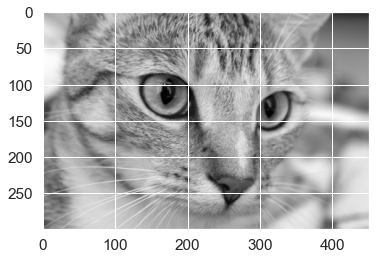

In [3]:
cat = iio.imread("imageio:chelsea.png", pilmode='L')
plt.imshow(cat, cmap='gray')

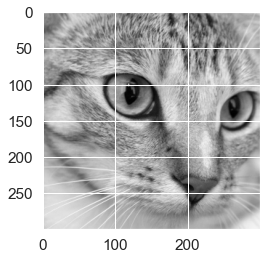

In [4]:
cat_2 = cat[:, 50:350] / 255
plt.imshow(cat_2, cmap="gray")

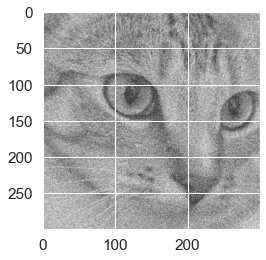

In [5]:
cat_noised = (cat_2 + 0.1 * np.random.randn(300,300))
plt.imshow(cat_noised, cmap="gray")

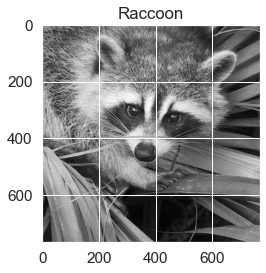

In [6]:
# Uploading and normalizing the image of raccoon
enot = (misc.face(gray = True)/255)[:, -768:]

# Plotting
plt.imshow(enot, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')
plt.show()

Пошумим? Добавим двухмерный гауссов шум с нулевым средним и задаваемой дисперсией
$$
y = enot(x,y) + \mathcal{N}(0, \sigma)
$$

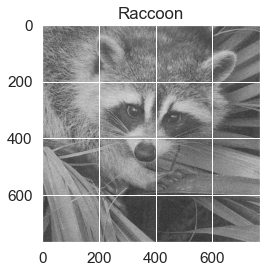

In [7]:
# Enot's size
n = enot.shape[1]

# Add some noise
sigma = 0.1
y = (enot + sigma * np.random.randn(n,n))

# Plotting
plt.imshow(y, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')
plt.show()

Как видим, изображение кота имеет меньше размеры чем енот, поэтому будем работать с ним дабы ускорить вычисления.

Задача заключается в том, как, имея только шумное изображение $y$, получить максимально близкое к исходному (как минимум, менее шумное). Наша задача будет формулироваться следующим образом: 

$$
\min_{x \in R^d} f(x) = \frac{1}{2} \|y-x\|^2 + \lambda J(x),
$$

где $J(x)$ - некоторая функция, которая характеризует шумность (зернистость) картинки. То есть, решая задачу оптимизации мы должны получить с одной стороны изображение, близкое к $y$, с другой стороны, как можно менее шумное. Остается один важный вопрос - *что из себя представляет функция $J(x)$?*

### Подход бедных студентов
В каждой точке изображения можно посчитать производную по двум координтам. Таким образом, если изображение это функция $enot(x, y): \mathbb{R}^d \to \mathbb{R}$, то её градиент - это функция $\nabla enot(x,y): \mathbb{R}^d \to \mathbb{R}^2$, представляющая в каждой точке вектор из двух компонент $\left( \dfrac{\partial \;enot}{\partial x}, \dfrac{\partial \;enot}{\partial y} \right)$. Полный набор по все точкам - тензор размера $n \times n \times 2$

Величина градиента в каждой точке может быть оценена как

$$
g(x_i, y_i) = \sqrt{\left(\dfrac{\partial \;enot}{\partial x} (x_i, y_i)\right)^2 + \left(\dfrac{\partial \;enot}{\partial y} (x_i, y_i)\right)^2}
$$

Тогда будем строить $J(x)$ следующим образом:
$$
J(x) = \sum\limits_{x_i,y_i} \left[g(x_i, y_i)^2 \right]
$$

Тогда он будет характеризовать некоторую кумулятивную величину изменения значения пикселя по всему изображению. [Метод конечных разностей](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D1%8B%D1%85_%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) поможет оценить величину частной производной. Для решения проблемы с граничными значениями можно, например, считать, что изображение циклично продолжается по сторонам (т.е. следующие столбец/ строка после последнего - это первый).
$$
\nabla enot(x_i, y_i) = \left(enot(x_{i+1}, y_{i}) - enot(x_{i}, y_{i}), enot(x_{i}, y_{i+1}) - enot(x_{i}, y_{i})  \right)
$$

In [11]:
## Ваш код

# Напишите функцию, которая принимает на вход черно-белое изображение nxn пикселей, а возвращает тензор размера nxnx2,
# содержащий частные производные в каждой точке, рассчитанный по методу конечных разностей.
def grad(x):
    x_left = np.roll(x, -1, axis=1)
    x_up = np.roll(x, -1, axis=0)
    return np.stack((x_left - x, x_up - x), axis=2)

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает матрицу размера nxn,
# содержащую величину градиента в квадрате в каждой точке.
def grad_magnitude(x):
    """returns the squared norm of the gradient of x"""
    grads = grad(x)
    return np.sum(np.square(grads), axis=2)

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def J(x):
    return np.sum(grad_magnitude(x))

def matrix_norm_squared(X):
    """get squared Frobenius norm of a matrix"""
    return np.sum(np.square(X))

# Напишите функцию, которая считает функцию потерь. (она возвращает число)
def f(x, y, lambd):
    return matrix_norm_squared(y - x) / 2 + lambd * J(x)

Для решения задачи методом градиентого спуска необходимо записать градиент целевой функции:
$$
\nabla f(x) = x-y + \lambda \nabla J(x)
$$
Вам предлагается самостоятельно предложить способ подсчета градиента функции $J(x)$. Заметим, что здесь есть широкий простор для творчества (начиная от аналитического вывода формулы и введения гессиана изображения, заканчивая, опять же, разностными схемами первого порядка). Поощрается Ваша интуиция и любое решение, подкрепленное убедительной мотивацией.

Имеем:
\begin{gather*}
J( X) =\sum _{i=1}^{n}\sum _{j=1}^{n}\left[( X_{( i+1) \ \%\ n+1,j} -X_{ij})^{2} +( X_{i,( j+1) \ \%\ n+1} -X_{ij})^{2}\right]\\
\frac{\partial J( X)}{\partial X_{ij}} =\frac{\partial }{\partial X_{ij}}\left[( X_{ij} -X_{i-1,j})^{2} +( X_{i-1,j+1} -X_{i-1,j})^{2}\right] +\\
+\frac{\partial }{\partial X_{ij}}\left[( X_{ij} -X_{i+1,j})^{2} +( X_{ij} -X_{i,j+1})^{2}\right] +\\
+\frac{\partial }{\partial X_{ij}}\left[( X_{ij} -X_{i,j-1})^{2} +( X_{i+1,j-1} -X_{i,j-1})^{2}\right] =\\
=2\cdotp [( X_{ij} -X_{i-1,j}) +( X_{ij} -X_{i,j-1}) +( X_{ij} -X_{i+1,j}) +( X_{ij} -X_{i,j+1})]
\end{gather*}
Тут $\displaystyle i-1=\begin{cases}
n & i=1\\
i-1 & i >1
\end{cases}\text{ и } i+1=\begin{cases}
1 & i=n\\
i+1 & i< n
\end{cases}$. Аналогично с индексом $\displaystyle j$.

Тогда, пусть:
- $\displaystyle A_{u}$ - циклический сдвиг строк матрицы $\displaystyle A$ на один шаг вверх;
- $\displaystyle A_{d}$ - циклический сдвиг строк матрицы $\displaystyle A$ на один шаг вниз;
- $\displaystyle A_{r}$ - циклический сдвиг столбцов матрицы $\displaystyle A$ на один шаг вправо;
- $\displaystyle A_{l}$ - циклический сдвиг столбцов матрицы $\displaystyle A$ на один шаг влево;


После определения этих операций уже можно легко определить $\displaystyle \nabla J( X)$:
$$
\begin{equation*}
\nabla J( X) =2\cdotp [( X-X_{u}) +( X-X_{r}) +( X-X_{d}) +( X-X_{l})]
\end{equation*}
$$

In [12]:
# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ(x):
    x_u = np.roll(x, -1, axis=0)
    x_d = np.roll(x, 1, axis=0)
    x_l = np.roll(x, -1, axis=1)
    x_r = np.roll(x, 1, axis=1)
    return 2 * (4 * x - x_u - x_d - x_r - x_l)

# Напишите функцию, которая считает градиент функции f(x) (она возвращает массив nxn)
def df(x, y, lamd):
    return x - y + lamd * dJ(x)

Тогда градиентный спуск здесь будет выглядеть следующим образом:
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k), \;\;\;\;\; x_0 = y
$$

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [13]:
import math

max_iter = 300
eps = 1e-4


def gradient_descent(
    eta, 
    lamd, 
    y=cat_noised, 
    epsilon=eps, 
    n_iter=max_iter, 
    is_second_approach=False, 
    function=f, 
    gradient=df
):
    functions = []
    gradients = []
    steps = []
    x = y.copy()
    converged = False
    for i in range(1, n_iter + 1):
        step_coeff = 1.0
        if is_second_approach:
            step_coeff /= float(i)
        steps.append(step_coeff * eta)
        x = x - step_coeff * eta * gradient(x, y, lamd)
        grad_norm = np.linalg.norm(gradient(x, y, lamd))
        if math.isnan(grad_norm) or math.isinf(grad_norm):
            converged = False
            break;
        functions.append(function(x, y, lamd))
        gradients.append(grad_norm)
        if grad_norm <= epsilon:
            converged = True
            break
    if i >= n_iter:
        converged = False
    if not converged:
        x = np.zeros(y.shape)
    return (x, functions, gradients, steps)

def plot_result_image(original, noised, denoised):
    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("original")
    ax[1].set_title("noised")
    ax[1].imshow(noised, cmap='gray')
    ax[2].set_title("denoised")
    ax[2].imshow(denoised, cmap='gray')
    plt.show()

def plot_results(sequence, title, figsize=(15, 8), color="orange"):
    plt.figure(figsize=figsize)
    sns.lineplot(x=np.arange(1, len(sequence) + 1), y=sequence, color=color)
    plt.title(f"Изменение {title} по итерациям", fontsize=22)
    plt.xlabel("номер итерации")
    plt.ylabel(title)
    plt.show()
    
def image_mse(orig, test):
    return np.sum(np.square(orig - test))

In [14]:
def poor_gradient_descent(eta, lamd, y=cat_noised, epsilon=eps, n_iter=max_iter, is_second_approach=False):
    return gradient_descent(eta, lamd, y, epsilon, n_iter, is_second_approach, f, df)

Напишем функцию которая подбирает оптимальные гиперпараметры для ГС используя ранее написанную ошибку для изображений `image_mse`.

In [15]:
from sklearn.model_selection import ParameterGrid

In [16]:
from copy import deepcopy

def tune_params(estimator, param_grid, original_image):
    min_error = np.inf
    best_ret = None
    best_params = None
    pg = ParameterGrid(param_grid)
    for param_set in pg:
        tmp_ret = estimator(**param_set)
        tmp_error = image_mse(original_image, tmp_ret[0])
        if tmp_error < min_error:
            min_error = tmp_error
            best_ret = deepcopy(tmp_ret)
            best_params = deepcopy(param_set)
    return (min_error, best_ret, best_params)

Затьюним параметры с выбором шага первой стратегией:

In [17]:
param_grid = {
    'eta': [0.01, 0.1, 1, 5],
    'lamd': [0.001, 0.01, 0.5, 1, 5]
}

tuned_ret = tune_params(poor_gradient_descent, param_grid, cat_2)
tuned_ret[0], tuned_ret[2]

(131.91501952614195, {'eta': 0.1, 'lamd': 1})

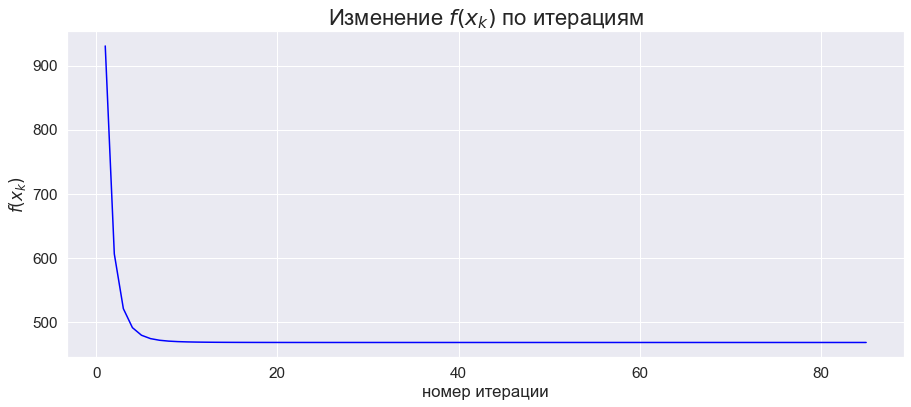

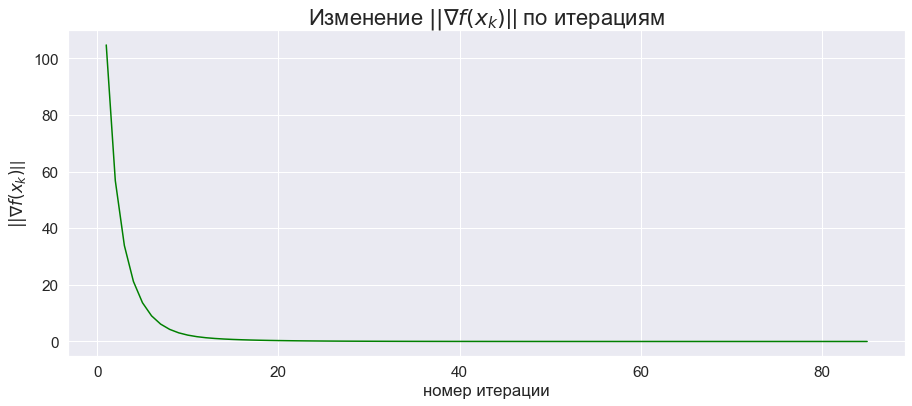

In [18]:
plot_results(tuned_ret[1][1], "$f(x_k)$", figsize=(15, 6), color="blue")
plot_results(tuned_ret[1][2], "$||\\nabla f(x_k)$||", figsize=(15, 6), color="green")

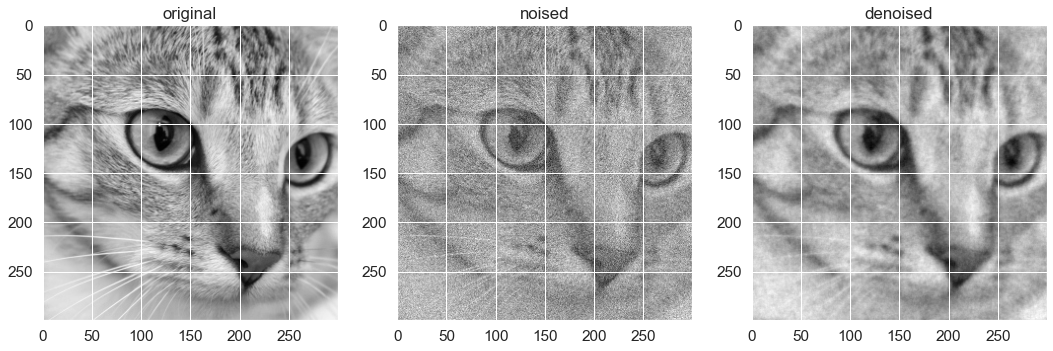

In [19]:
plot_result_image(cat_2, cat_noised, tuned_ret[1][0])

Теперь второй стратегией:

In [20]:
param_grid_2 = {
    'eta': [0.01, 0.1, 1, 5],
    'lamd': [0.001, 0.1, 5],
    'is_second_approach': [True],
    'n_iter': [1500]
}

tuned_ret_2 = tune_params(poor_gradient_descent, param_grid_2, cat_2)
tuned_ret_2[0], tuned_ret_2[2]

(339.86201064442844,
 {'eta': 1, 'is_second_approach': True, 'lamd': 0.1, 'n_iter': 1500})

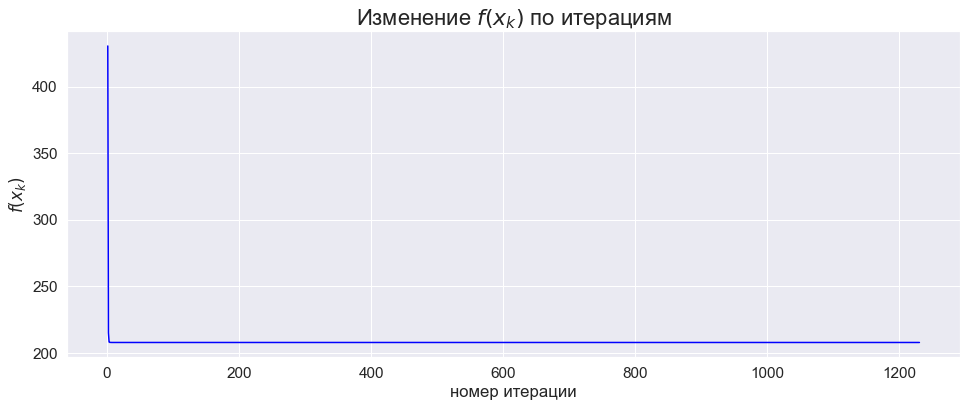

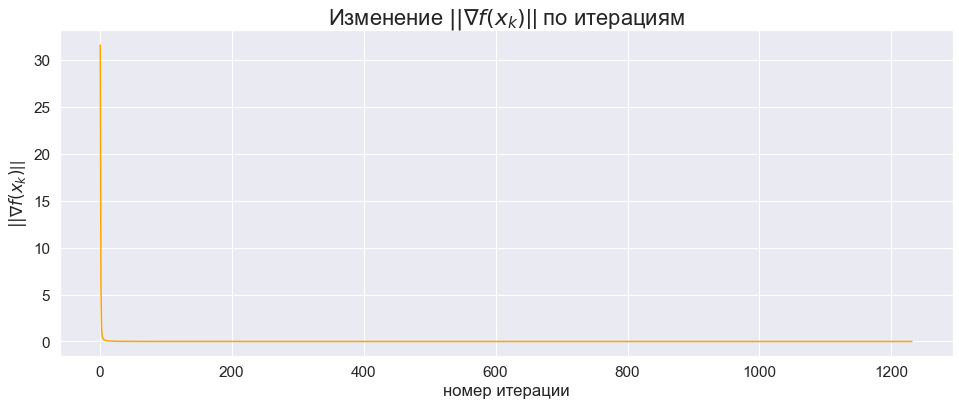

In [21]:
plot_results(tuned_ret_2[1][1], "$f(x_k)$", figsize=(16, 6), color="blue")
plot_results(tuned_ret_2[1][2], "$||\\nabla f(x_k)$||", figsize=(16, 6), color="orange")

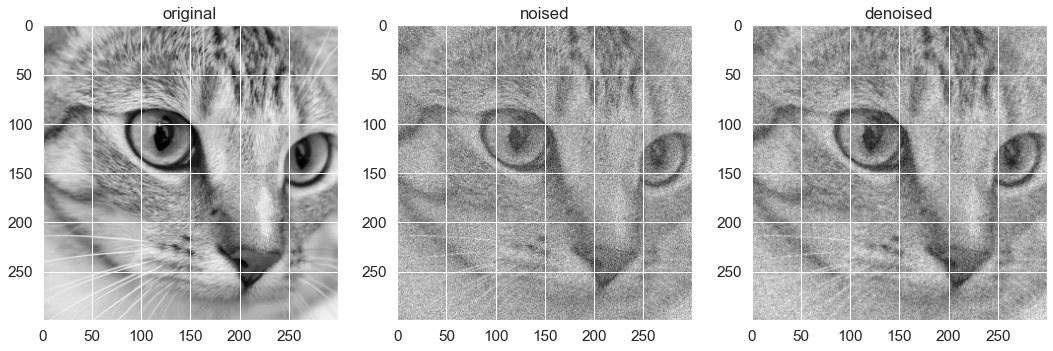

In [22]:
plot_result_image(cat_2, cat_noised, tuned_ret_2[1][0])

Как можно увидеть, оптимальный шаг для второй стратегии оказался 10 раз больше чем в первой стратегии, что достаточно естесственно, т.к. шаг с каждой итерацией все равно уменьшается. При этом результат намного хуже. Убывающим шагом мы просто увеличили количество итераций алгоритма. Так же не получить сходимость за разумное количество итераций когда взял лямбду как в первой итерации, пришлось взять поменьше значения, из-за этого результат получился шумнее чем в предыдущей стратегии.

### Подход богатых студентов (Total Variation Denoising)
[Здесь](http://www.numerical-tours.com/matlab/optim_1_gradient_descent/) можно почитать мануал на [тему](https://en.wikipedia.org/wiki/Total_variation_denoising). Реализуйте функции $J(x)$ и $\nabla J(x)$ в этом подходе согласно мануалу.

In [23]:
var_eps = 1e-2


def rich_grad(x):
    x_r = np.roll(x, 1, axis=1)
    x_d = np.roll(x, 1, axis=0)
    return np.stack((x - x_d, x - x_r), axis=2)


def rich_grad_magnitude(x):
    return np.sum(np.square(rich_grad(x)), axis=2)


def eps_norm(x):
    return np.sqrt(np.square(var_eps) + rich_grad_magnitude(x))
    
# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def J_tv(x):
    return np.sum(eps_norm(x))

# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ_tv(x):
    GX = rich_grad(x)
    GX_eps_norm = eps_norm(x)
    
    u_1 = GX[:, :, 0] / GX_eps_norm
    u_2 = GX[:, :, 1] / GX_eps_norm
    
    u_1_up = np.roll(u_1, -1, axis=0)
    u_2_left = np.roll(u_2, -1, axis=1)
    
    divergence = -u_1_up + u_1 - u_2_left + u_2
    
    return divergence

In [24]:
def f_tv(x, y, lambd):
    return matrix_norm_squared(y - x) / 2 + lambd * J_tv(x)

def df_tv(x, y, lambd):
    return x - y + lambd * dJ_tv(x)

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [25]:
def tv_gradient_descent(eta, lamd, y=cat_noised, epsilon=eps, n_iter=max_iter, is_second_approach=False):
    return gradient_descent(eta, lamd, y, epsilon, n_iter, is_second_approach, f_tv, df_tv)

In [26]:
test_ret_0 = tv_gradient_descent(eta=0.02, n_iter=1000, lamd=0.1, is_second_approach=False)
test_ret_0[0]

Array([[0.51751545, 0.52118708, 0.52248453, ..., 0.61067453, 0.61348489,
        0.5471784 ],
       [0.52109848, 0.5198905 , 0.46649197, ..., 0.5989142 , 0.54515697,
        0.54332114],
       [0.49272054, 0.47171588, 0.46379778, ..., 0.55156835, 0.55174633,
        0.54242897],
       ...,
       [0.56210549, 0.56060225, 0.55591124, ..., 0.65614836, 0.64304663,
        0.64881079],
       [0.54060586, 0.5324921 , 0.53522945, ..., 0.644619  , 0.64052249,
        0.58460975],
       [0.52835208, 0.52490936, 0.526764  , ..., 0.64708228, 0.63827872,
        0.58120222]])

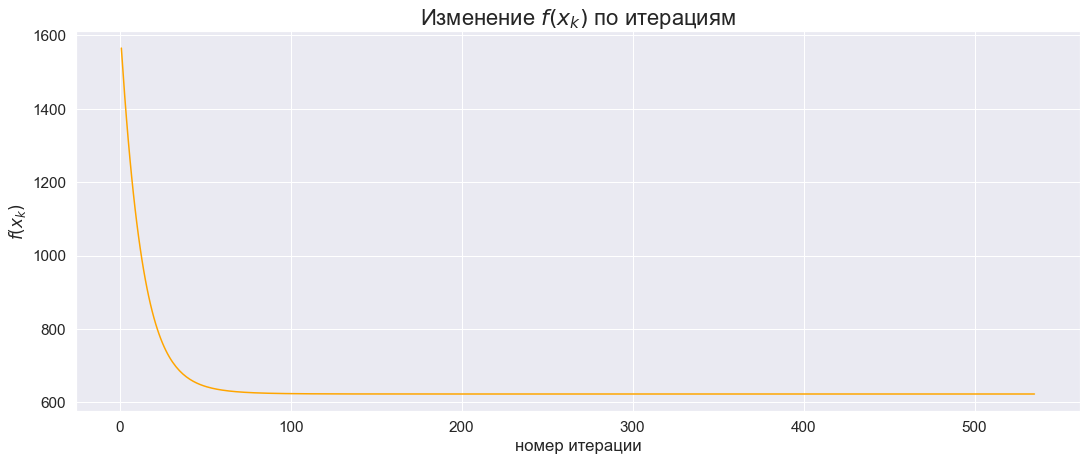

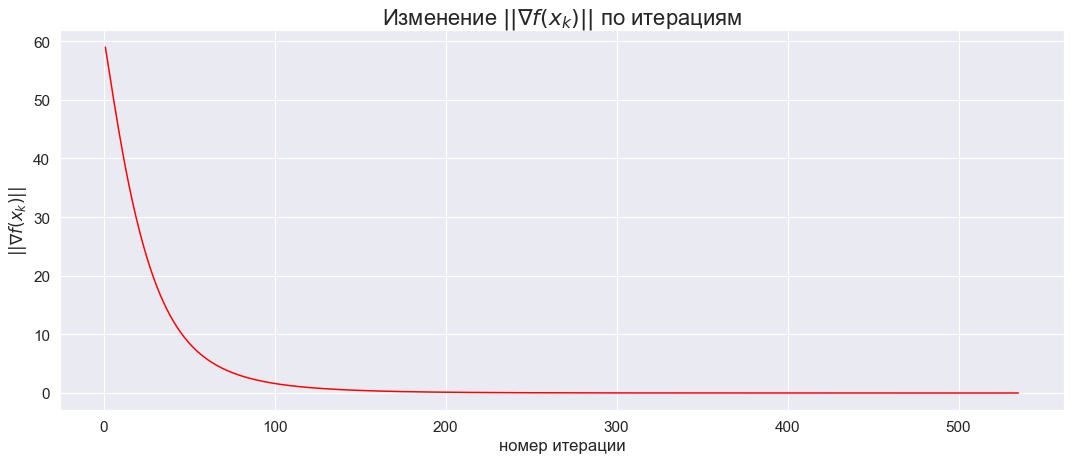

In [27]:
plot_results(test_ret_0[1], "$f(x_k)$", figsize=(18, 7))
plot_results(test_ret_0[2], "$||\\nabla f(x_k)||$", figsize=(18, 7), color='red')

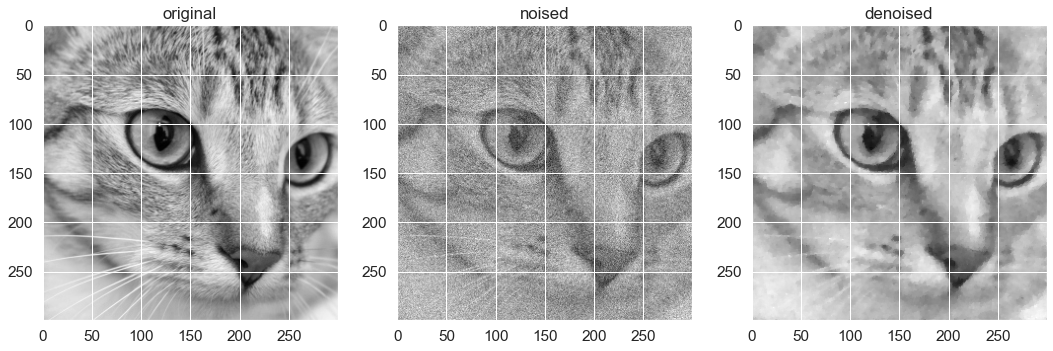

In [28]:
plot_result_image(cat_2, cat_noised, test_ret_0[0])

In [29]:
image_mse(test_ret_0[0], cat_2)

128.92495598555502

Получили результат лучше чем было в бедном подходе.

In [30]:
test_ret_1 = tv_gradient_descent(eta=0.012, n_iter=1000, lamd=0.2, is_second_approach=False)
test_ret_1[0]

Array([[0.53466649, 0.53312514, 0.53099504, ..., 0.59857886, 0.5945511 ,
        0.55235206],
       [0.53093605, 0.52664086, 0.48946246, ..., 0.58614142, 0.55012984,
        0.54473338],
       [0.51311175, 0.49227885, 0.48158004, ..., 0.55236736, 0.54931165,
        0.53888528],
       ...,
       [0.58590357, 0.57788173, 0.57208618, ..., 0.64115368, 0.63034722,
        0.62849459],
       [0.56421714, 0.55298929, 0.55132466, ..., 0.62905754, 0.62334991,
        0.59341201],
       [0.54730732, 0.54085535, 0.53965342, ..., 0.62531729, 0.61489042,
        0.58117411]])

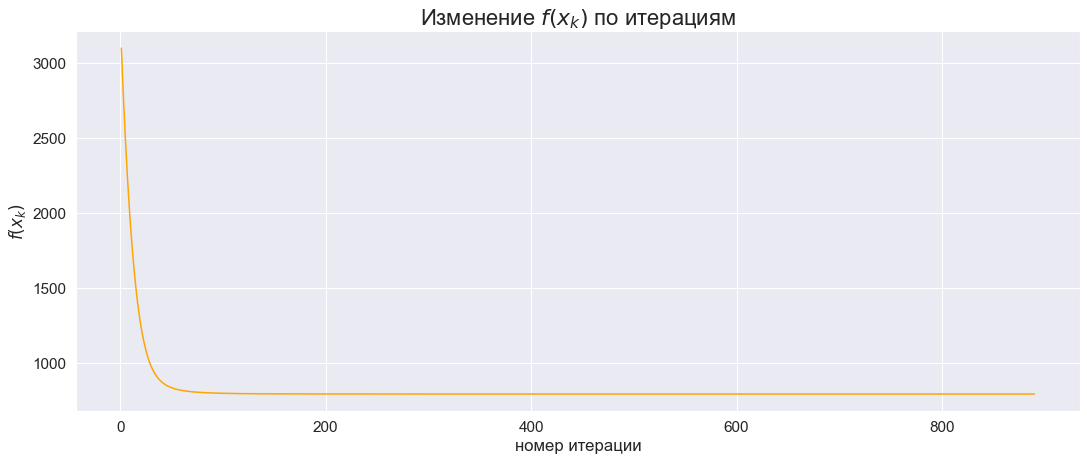

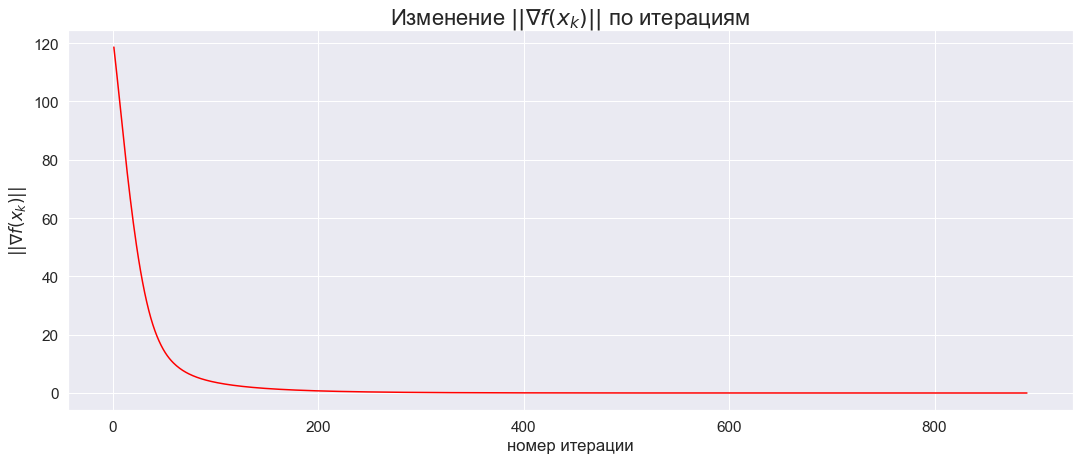

In [31]:
plot_results(test_ret_1[1], "$f(x_k)$", figsize=(18, 7))
plot_results(test_ret_1[2], "$||\\nabla f(x_k)||$", figsize=(18, 7), color='red')

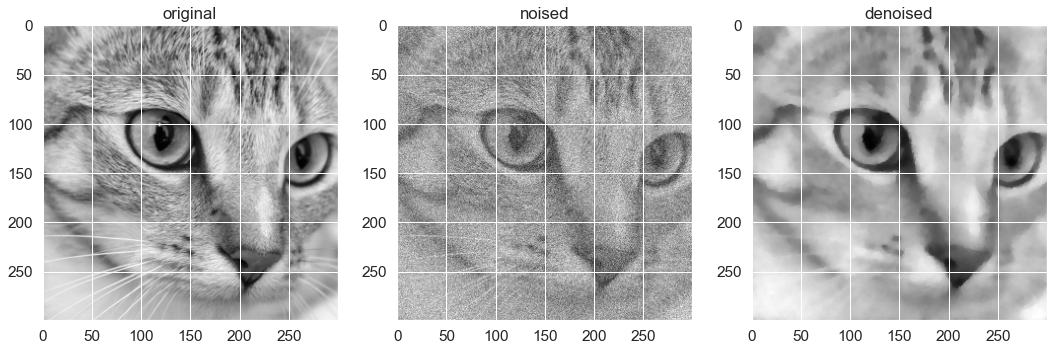

In [32]:
plot_result_image(cat_2, cat_noised, test_ret_1[0])

In [33]:
image_mse(test_ret_1[0], cat_2)

188.3223019774755

С этими параметрами результат стал более размытым, и ошибка намного выше чем в предыдущем пункте.

In [34]:
test_ret_2 = tv_gradient_descent(eta=1e-5, n_iter=1000, lamd=1, is_second_approach=False)
test_ret_2[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

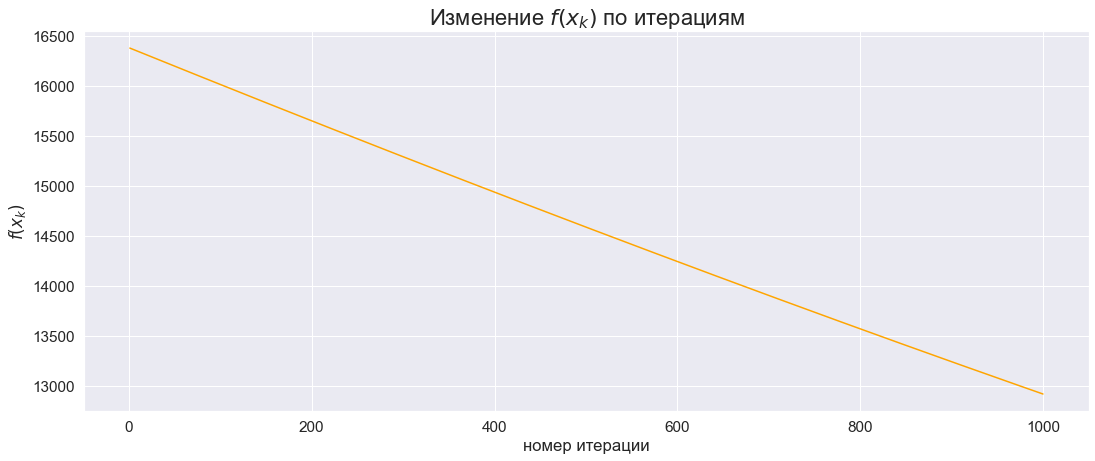

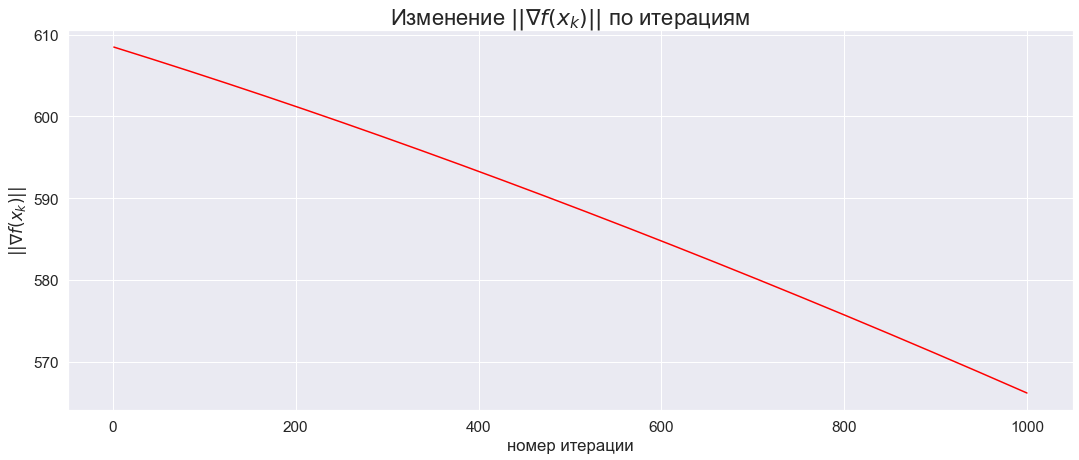

In [35]:
plot_results(test_ret_2[1], "$f(x_k)$", figsize=(18, 7))
plot_results(test_ret_2[2], "$||\\nabla f(x_k)||$", figsize=(18, 7), color='red')

__Наблюдение__: Как можно увидеть, большие значения регляризатора требуют очень маленький размер шага, что сильно замедляет сходимость. А при слишком маленьких значениях гиперпараметра очевидно получаем очень быструю сходимость, но полученный результат будет таким же шумным.

Теперь рассмотрим вторую стратегию выбора шага. Мы поняли, что рассматривать различные значения регуляризатора тут без толку, т.к. зависимость между регуляризатором и шагом мы поняли в предыдущем пункте. Сейчас рассмотрим как отличается изначальный шаг от первой стратегии.

In [36]:
test_ret_3 = tv_gradient_descent(eta=2, n_iter=2000, lamd=0.1, is_second_approach=True)
test_ret_3[0]

Array([[0.51751526, 0.52118688, 0.52248433, ..., 0.61067485, 0.61348522,
        0.54717831],
       [0.52109832, 0.51989033, 0.4664921 , ..., 0.5989145 , 0.54515689,
        0.54332105],
       [0.49272054, 0.471716  , 0.46379791, ..., 0.5515683 , 0.55174627,
        0.54242889],
       ...,
       [0.56210536, 0.56060206, 0.55591102, ..., 0.65614873, 0.64304699,
        0.64881111],
       [0.54060567, 0.53249189, 0.53522923, ..., 0.64461938, 0.64052286,
        0.5846098 ],
       [0.52835188, 0.52490915, 0.52676378, ..., 0.64708266, 0.6382791 ,
        0.58120228]])

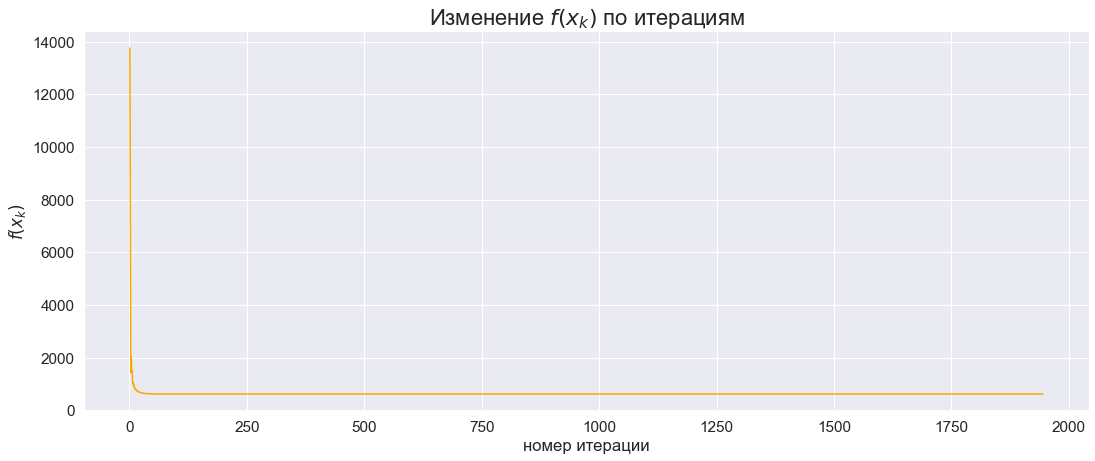

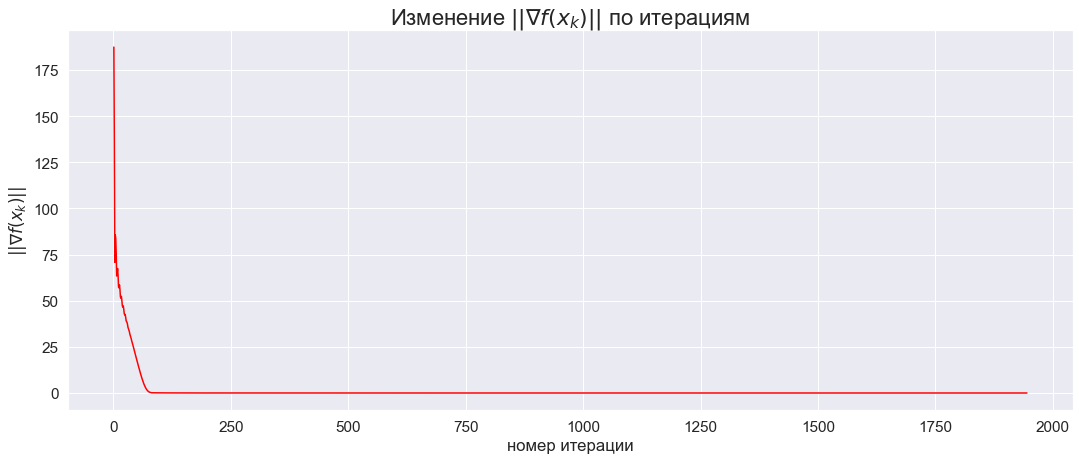

In [37]:
plot_results(test_ret_3[1], "$f(x_k)$", figsize=(18, 7))
plot_results(test_ret_3[2], "$||\\nabla f(x_k)||$", figsize=(18, 7), color='red')

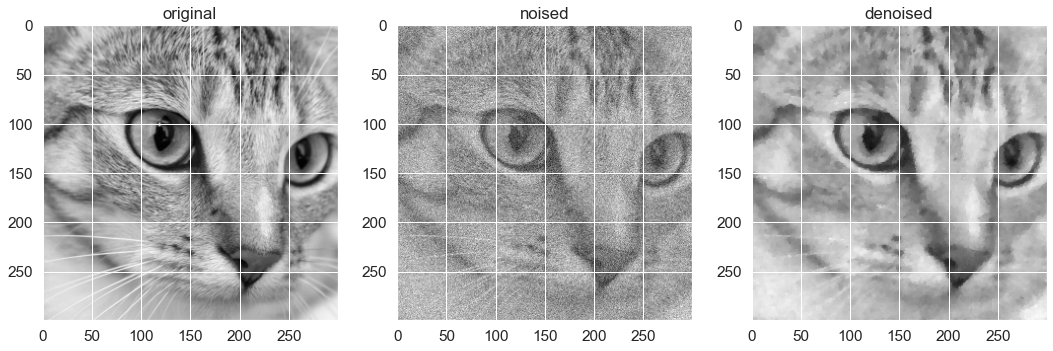

In [38]:
plot_result_image(cat_2, cat_noised, test_ret_3[0])

In [39]:
image_mse(cat_2, test_ret_3[0])

128.925063893042

Мы добились такого же результата, что и с константым шагом, только за количество итераций несколько кратно раз большего :(
Из графика, а точнее из-за скачков значения функций, так же можно сказать, что стоило бы взять изначальный шаг поменьше, но следующий эксперимент покажет, что тогда сходимость очень сильно замедлится и мы сойдемся либо за огромное количество итераций, либо вообще не сойдемся.

In [40]:
test_ret_4 = tv_gradient_descent(eta=0.2, n_iter=3000, lamd=0.1, is_second_approach=True)
test_ret_4[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

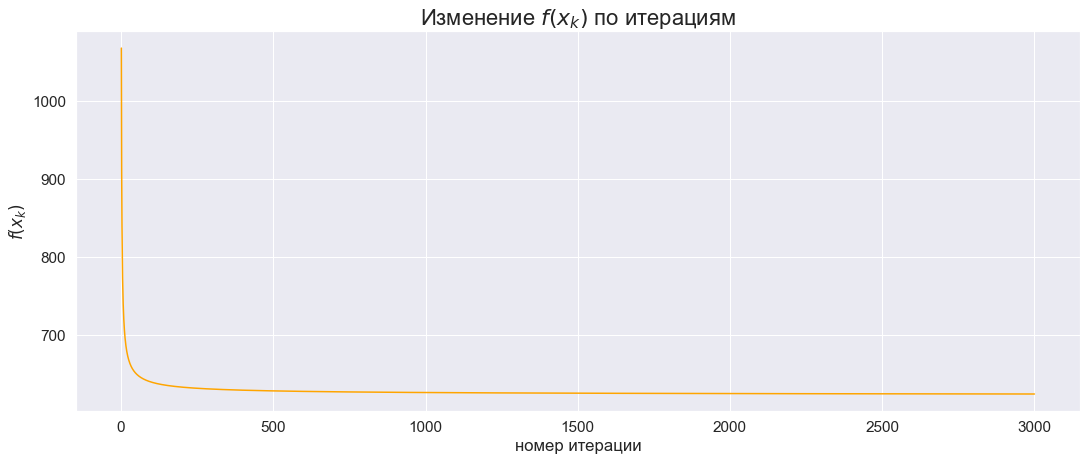

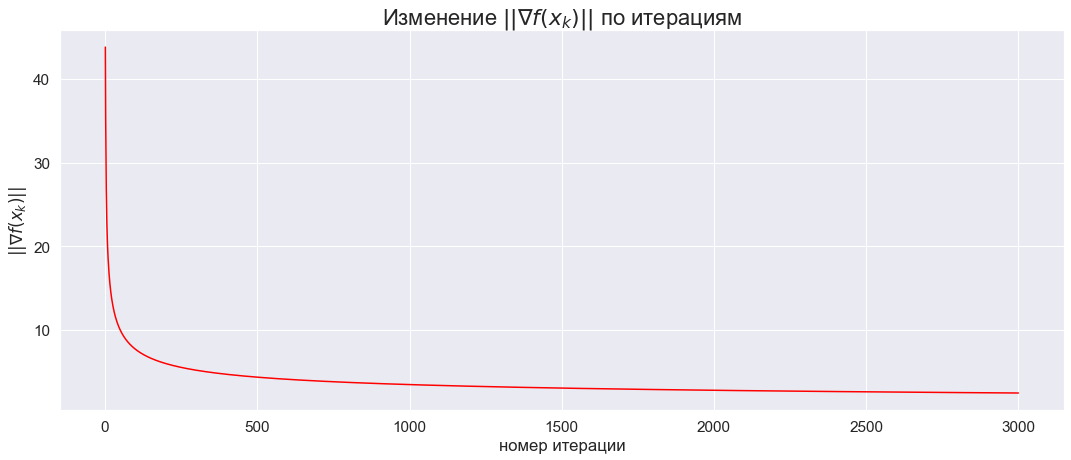

In [41]:
plot_results(test_ret_4[1], "$f(x_k)$", figsize=(18, 7))
plot_results(test_ret_4[2], "$||\\nabla f(x_k)||$", figsize=(18, 7), color='red')

Взяли шаг в 10 раз меньше чем предыдущий эксперимент, и получили что даже за 40 итераций не сошлось. Значение функции слишком сильно замедлилось уменьшаться.